<a href="https://colab.research.google.com/github/varunsboy17/PneumoniaPredictor_with_ChestXRays/blob/master/PnuemoniaPredictorChestXRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip install kaggle
import gc
import os
import re
import cv2
import shutil
import time
import datetime
import random
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

In [21]:
os.environ['KAGGLE_USERNAME'] = "varunyadav17"
os.environ['KAGGLE_KEY'] = "2073c7a8d526d9d351df6f8f499e6080"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia/downloads/chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
def create_directory(directory, remove=False):
  if remove and os.path.exists(directory):
    try:
      shutil.rmtree(directory)
      os.mkdir(directory)
    except:
      print("Could not remove directory : ", directory)
      return False
  else:
    try:
      os.mkdir(directory)
    except:
      print("Could not create directory : ", directory)
      return False
  return True
  
def clear_directory(directory):
  dirs_files = os.listdir(directory)
  
  for item in dirs_files:
    item_path = directory + item
    
    try:
      if os.path.isfile(item_path):
        os.unlink(item_path)
      elif os.path.isdir(item_path):
        shutil.rmtree(item_path)
    except Exception as e:
      print(e)
      
  return True

def remove_empty_folders(path, removeRoot = True):
  if not os.path.isdir(path):
    return
  
  files = os.listdir(path)
  
  if len(files):
    for f in files:
      full_path = os.path.join(path, f)
      
      if(os.path.isdir(full_path)):
        remove_empty_folders(full_path)
        
  files = os.listdir(path)
  
  if(len(files) == 0 and removeRoot):
    print("Removing empty folder : ", path)
    os.rmdir(path)
  
def dir_file_count(directory):
  return sum([len(files) for r, d, files in os.walk(directory)])

In [0]:
def date_time(x):
  if x == 1:
    return 'Timestamp: {:%Y-%m-%d %H-%M-%S}'.format(datetime.datetime.now())
  if x == 2:
    return 'Timestame: {:%Y-%b-%d %H-%M-%S}'.format(datetime.datetime.now())
  if x == 3:
    return 'Datetime now; %s' % datetime.datetime.now()
  if x == 4:
    return 'Datetime today; %s' % datetime.datetime.today()

In [0]:
# Remove everything except aplhanumeric and selected characters from string
def name_correct(name):
  return re.sub('[^a-zA-Z,:]', ' ', name).title()

In [0]:
def reset_graph(model=True):
  if model:
    try:
      del model
    except:
      return False
    
  tf.reset_default_graph()
  K.clear_session()
  gc.collect()
  return True

def reset_callbacks(checkpoint = None, reduce_lr = None, early_stopping = None, tensorboard = None):
  checkpoint = None
  reduce_lr = None
  early_stopping = None
  tensorboard = None

**Data Visualization**

In [0]:
def get_reset_subplot_params(nrows, ncols, dpi):
  subplot_params = {}
  subplot_params['nrows'] = nrows
  subplot_params['ncols'] = ncols
  
  subplot_params['figsize_row'] = subplot_params['nrows'] * 2.5
  subplot_params['figsize_col'] = subplot_params['ncols'] * 2.5
  subplot_params['dpi'] = dpi
  subplot_params['facecolor'] = 'w'
  subplot_params['edgecolor'] = 'k'
  subplot_params['subplot_kw'] = {'xticks':[], 'yticks':[]}
  subplot_params['axes.titlesize'] = 'small'
  subplot_params['hspace'] = 0.5
  subplot_params['wspace'] = 0.3
  
  return subplot_params

def get_reset_plot_params(figsize=(15,5), title="", xlabel="", ylabel="", legends=[], title_fontsize=18, label_fontsize=14, 
                         image_file_name="", save=False, dpi=100, update_image=True):
  plot_params = {}
  plot_params['figsize'] = figsize
  plot_params['title'] = title
  plot_params['xlabel'] = xlabel
  plot_params['ylabel'] = ylabel
  plot_params['legends'] = legends
  plot_params['title_fontsize'] = title_fontsize
  plot_params['axes_titlesize'] = "small"
  plot_params['label_fontsize'] = label_fontsize
  plot_params['image_file_name'] = image_file_name
  plot_params['save'] = save
  plot_params['update_image'] = update_image
  plot_params['subplot'] = None
  return plot_params

In [0]:
def select_image_by_category(directory, image_count_per_category):
  classes = [f for f in os.listdir(directory) if not f.startswith('.')]
      
  classes_count = len(classes)
  
  image_file_path = {}
  
  for i in range(classes_count):
    subdir_path = directory + "/" + classes[i]
    subdir_files = os.listdir(subdir_path)
    subdir_file_count = len(subdir_files)
    
    subdir_file_mem = {}
    
    subdir_file_index = -1
    
    image_file_path[classes[i]] = []
    
    for j in range(image_count_per_category):
      while subdir_file_index in subdir_file_mem:
        subdir_file_index = random.randint(0, subdir_file_count - 1)
      subdir_file_mem[subdir_file_index] = 1
      
      subdir_file_name = subdir_files[subdir_file_index]
      subdir_file_path = subdir_path + "/" + subdir_file_name
      
      image_file_path[classes[i]].append(subdir_file_path)
      
  return image_file_path

def get_fig_axs(subplot_params):
  fig, axs = plt.subplots(nrows = subplot_params['nrows'], ncols = subplot_params['ncols'], figsize = (subplot_params['figsize_col'], subplot_params['figsize_row']),
                         dpi = subplot_params['dpi'], facecolor = subplot_params['facecolor'], edgecolor = subplot_params['edgecolor'], subplot_kw = 
                         subplot_params['subplot_kw'])
  return fig, axs
  
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
  fig, axs = get_fig_axs(subplot_params)
  plt.rcParams.update({'axes.titlesize':subplot_params['axes.titlesize']})
  plt.subplots_adjust(hspace = subplot_params['hspace'], wspace = subplot_params['wspace'])
  
  i = 0
  for img_file_path in image_file_paths:
    img = cv2.imread(img_file_path, 1)
    plt.subplot(subplot_params['nrows'], subplot_params['ncols'], i + 1)
    plt.imshow(img)
    plt.title(img_file_path.split('/')[-1])
    
    plt.xticks([])
    plt.yticks([])
    
    i = i + 1
    
  if plot_params['update_image'] and os.path.exists(plot_params['image_file_name']):
    os.remove(plot_params['image_file_name'])
    
  if plot_params['save']:
    fig.savefig(plot_params['image_file_name'], dpi = plot_params['dpi'])
    
  plt.tight_layout()
  plt.show()
  
def show_class_sample_images(directory, image_count_per_category = 5, save = False, dpi = 100, update_image=False):  
  class_count = len([f for f in os.listdir(directory) if not f.startswith('.')])
      
  print("Num classes: ", class_count)
  sample_img_by_class = select_image_by_category(directory, image_count_per_category)
  for class_name in sample_img_by_class:
    plot_params = get_reset_plot_params(image_file_name="img.png", save=save, dpi=dpi, update_image=update_image)
    subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
    print("%s%s%s"%('-'*75, name_correct(class_name), '-'*75))
    plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
    print("")

In [0]:
def subdirectory_file_count(master_dir):
  subdirs = [f for f in os.listdir(master_dir) if not f.startswith('.')]
  subdirs_count = len(subdirs)
  
  subdirs_names = []
  subdirs_file_counts = []
  
  for subdir in subdirs:
    current_dir = os.path.join(master_dir, subdir)
    file_count = len(os.listdir(current_dir))
    subdirs_names.append(subdir)
    subdirs_file_counts.append(file_count)
    
  return subdirs_names, subdirs_file_counts
  
def bar_plot(x, y, plot_property):
  if plot_property['subplot']:
    plt.subplot(plot_property['subplot'])
  sns.barplot(x=x, y=y)  
  plt.title(plot_property['title'], fontsize = plot_property['title_fontsize'])
  plt.title(plot_property['xlabel'], fontsize = plot_property['label_fontsize'])
  plt.title(plot_property['ylabel'], fontsize = plot_property['label_fontsize'])
  plt.xticks(range(len(x)), x)
    
def count_bar_plot(master_dir, plot_property):
  dir_name, dir_file_count = subdirectory_file_count(master_dir)
  x = [name_correct(i) for i in dir_name]
  y = dir_file_count
  bar_plot(x, y, plot_property)
  return
  
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
  plt.figure(figsize = plot_property['figsize'])
  
  title = plot_property['title']
  plot_property['title'] = title + ' (Training)'
  subplot_no = plot_property['subplot']
  count_bar_plot(training_dir, plot_property)
  
  plot_property['title'] = title + '(Validation)'
  plot_property['subplot'] = subplot_no + 1
  count_bar_plot(validation_dir, plot_property)
  
  plot_property['title'] = title + '(Testing)'
  plot_property['subplot'] = subplot_no + 2
  count_bar_plot(testing_dir, plot_property)
  
  plt.show()

**Preprocessing**

In [0]:
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
  zip_ref.extractall('input')

In [0]:
with zipfile.ZipFile('/content/input/chest_xray.zip', 'r') as zip_ref:
  zip_ref.extractall('input')

In [0]:
reset_graph()
reset_callbacks()

In [0]:
input_directory = '/content/input/chest_xray/'
output_directory = '/content/output/'
  
if not os.path.exists(output_directory):
  os.mkdir(output_directory)

training_dir = input_directory + 'train'
testing_dir = input_directory + 'test'
validation_dir = input_directory + 'val'

figure_directory = output_directory + 'figures'

if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
file_name_pred_batch = figure_directory + "/result"
file_name_pred_sample = figure_directory + "/sample"

Num classes:  2
---------------------------------------------------------------------------Normal---------------------------------------------------------------------------


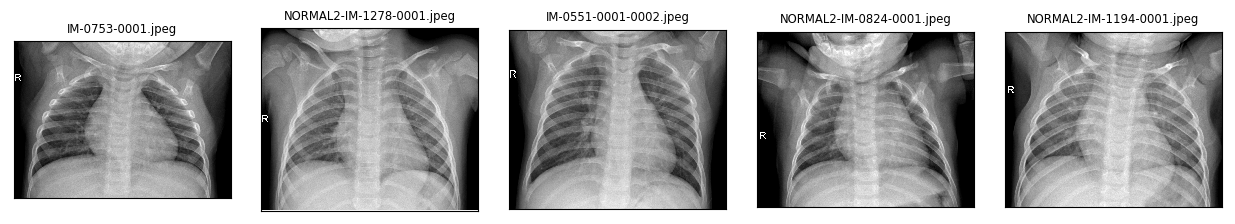


---------------------------------------------------------------------------Pneumonia---------------------------------------------------------------------------


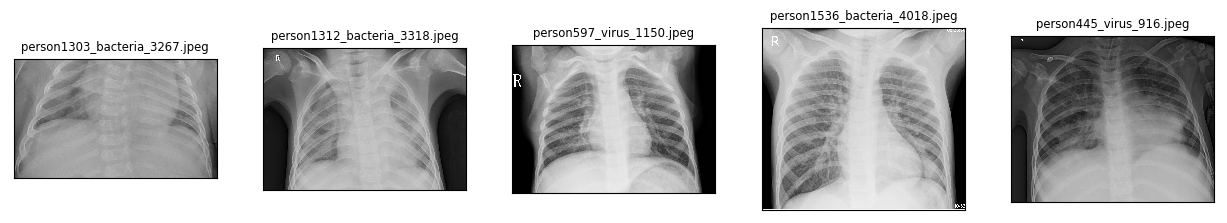

In [33]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)
#show_class_sample_images(training_dir)

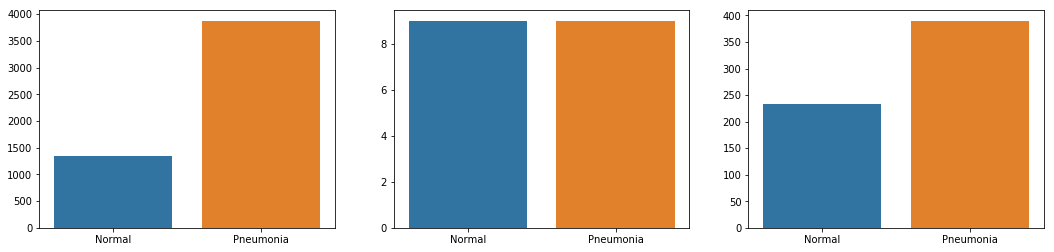

<class 'list'>


In [88]:
plot_params = get_reset_plot_params()
plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = 'Number of cases'

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = [f for f in os.listdir(training_dir) if not f.startswith('.')]
print(type(classes))
classes = [name_correct(i) for i in classes]

**Image Processing/Augmentation/Transformation for Training/Validation/Testing datasets**

In [0]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'

In [36]:
train_datagen = ImageDataGenerator(rescale = rescale, shear_range = 0.2, zoom_range= 0.1, horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(training_dir, target_size = target_size, batch_size = batch_size, class_mode = class_mode, shuffle = True)

val_datagen = ImageDataGenerator(rescale = rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, target_size = target_size, batch_size = dir_file_count(validation_dir), class_mode = class_mode, shuffle = False)

test_datagen = ImageDataGenerator(rescale = rescale)
test_generator = test_datagen.flow_from_directory(testing_dir, target_size = target_size, batch_size = dir_file_count(testing_dir), class_mode = class_mode, shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
from sklearn.utils import class_weight
def get_weight(y):
  class_weight_current = class_weight.compute_class_weight('balanced', np.unique(y), y)
  return class_weight_current

In [38]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

**Training Files Configuration**

In [0]:
main_model_dir = output_directory + r'models/'
main_log_dir = output_directory + r'logs/'

if not os.path.exists(main_model_dir):
  os.mkdir(main_model_dir)
  
if not os.path.exists(main_log_dir):
  os.mkdir(main_log_dir)
  
clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + '/'
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

**Callbacks**

In [0]:
reset_graph()
reset_callbacks()

In [41]:
print("Setting callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(model_file, monitor='val_acc', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights= True)
tensorboard = TensorBoard(log_dir = log_dir, batch_size = batch_size, update_freq = 'batch')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, cooldown = 2, min_lr = 0.0000000001, verbose = 1)

callbacks = [checkpoint, early_stopping, tensorboard, reduce_lr]

print("Set callbacks at ", date_time(1))

Setting callbacks at  Timestamp: 2019-09-21 13-06-30
Set callbacks at  Timestamp: 2019-09-21 13-06-31


In [0]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)))
  model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
  model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2), dim_ordering = 'tf'))
  
  model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
  model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2), dim_ordering = 'tf'))
  
  model.add(Conv2D(96, (3,3), dilation_rate = (2, 2), activation = 'relu', padding = 'same'))
  model.add(Conv2D(96, (3,3), activation = 'relu', padding = 'valid'))
  model.add(MaxPooling2D(pool_size = (2, 2), dim_ordering = 'tf'))
  
  model.add(Conv2D(128, (3,3), dilation_rate = (2, 2), activation = 'relu', padding = 'same'))
  model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'valid'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  
  model.add(Flatten())
  
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2, activation = 'softmax'))
  
  print(model.summary())
  
  return model

In [0]:
def get_model():
  base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
  x = base_model.output
  x = BatchNormalization()(x)
  predictions = Dense(2, activation = 'Softmax')(x)
  model = Model(inputs = base_model.input, outputs = predictions)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  model.summary()
  return model

**Training/Fine Tuning Base model - InceptionV3 for training with new class labels**

In [44]:
print("Getting base_model", date_time(1))

model = get_conv_model()

Getting base_model Timestamp: 2019-09-21 13-06-31



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (M

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`


In [45]:
print("Start training model ", date_time(1))

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

optimizer = optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epochs = 100

model.compile(optimizer, loss = loss, metrics = metrics)

history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs, verbose = 2, callbacks =
                             callbacks, validation_data = val_generator, validation_steps = validation_steps, class_weight = 
                              class_weight)

print("Completed model training ", date_time(1))

Start training model  Timestamp: 2019-09-21 13-06-32

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 412s - loss: 0.6030 - acc: 0.7306 - val_loss: 0.8447 - val_acc: 0.5000
Epoch 2/100
 - 401s - loss: 0.4962 - acc: 0.7627 - val_loss: 2.7516 - val_acc: 0.5625
Epoch 3/100
 - 400s - loss: 0.5055 - acc: 0.7803 - val_loss: 0.4752 - val_acc: 0.8125
Epoch 4/100
 - 399s - loss: 0.2734 - acc: 0.8811 - val_loss: 0.5007 - val_acc: 0.8125
Epoch 5/100
 - 400s - loss: 0.2414 - acc: 0.8992 - val_loss: 0.3143 - val_acc: 0.7500
Epoch 6/100
 - 399s - loss: 0.2098 - acc: 0.9086 - val_loss: 0.5229 - val_acc: 0.6875
Epoch 7/100
 - 400s - loss: 0.1846 - acc: 0.9248 - val_loss: 0.6926 - val_acc: 0.6875
Epoch 8/100
 - 401s - loss: 0.1519 - acc: 0.9369 - val_loss: 0.4886 - val_acc: 0.6875
Epoch 9/100
 - 401s - loss: 0.1439 - acc: 0.9408 - val_loss: 0.4394 - val_acc: 0.7500
Epoch 10/100
 - 408s - loss: 0.1434 - acc: 0.9427 - val_loss: 0.5197 - val_a

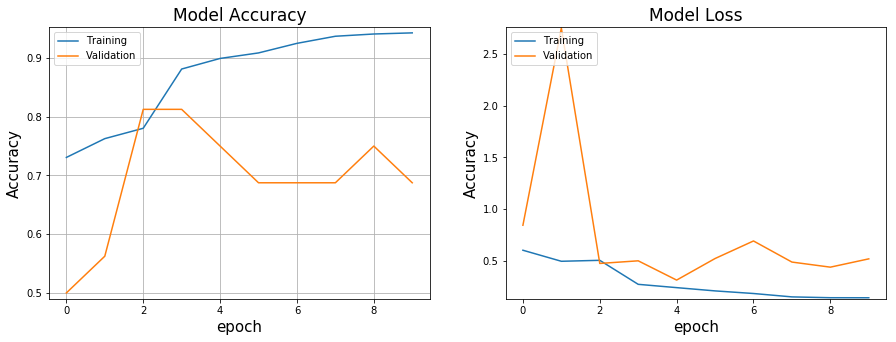

In [47]:
xlabel = "epoch"
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize = (15, 5))

# Plot training and validation accuracy

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2)) - ylim_pad[0]
max_y = max(max(y1), max(y2)) + ylim_pad[0]

plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize = 17)
plt.xlabel(xlabel, fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc = 'upper left')
plt.grid()

# Plot training and validation loss
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2)) - ylim_pad[0]
max_y = max(max(y1), max(y2)) + ylim_pad[0]

plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize = 17)
plt.xlabel(xlabel, fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc = 'upper left')
plt.show()

**Test Saved Models**

In [63]:
dir_name = 'output/models'
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
  print(i, dirs[i])

0 2019-09-21 13-06-29


In [70]:
cur_dir = dir_name + '/' + dirs[0] + '/'
print(cur_dir)
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
  print(i, model_names[i])

output/models/2019-09-21 13-06-29/
0 02-val_acc-0.56-val_loss-2.75.hdf5
1 03-val_acc-0.81-val_loss-0.48.hdf5
2 01-val_acc-0.50-val_loss-0.84.hdf5


In [71]:
model_file = cur_dir + model_names[0]
print(model_file)

output/models/2019-09-21 13-06-29/02-val_acc-0.56-val_loss-2.75.hdf5


In [0]:
from keras.models import load_model
model = load_model(model_file)

In [74]:
print("Results")
result = model.evaluate_generator(test_generator, steps = len(test_generator), verbose = 1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1] * 100, "%"))

Results
1/1 [==============================] - 22s 22s/step
Loss     : 1.84  
Accuracy : 67.79%


In [75]:
print("Results")
y_pred = model.predict_generator(test_generator, len(test_generator), verbose = 1)
y_pred = y_pred.argmax(axis = -1)
y_true = test_generator.classes

Results
1/1 [==============================] - 21s 21s/step


- 90
Derived Report
- 90
Precision     : 66.10%
Recall        : 99.49%
F1 Score      : 79.43%
- 90





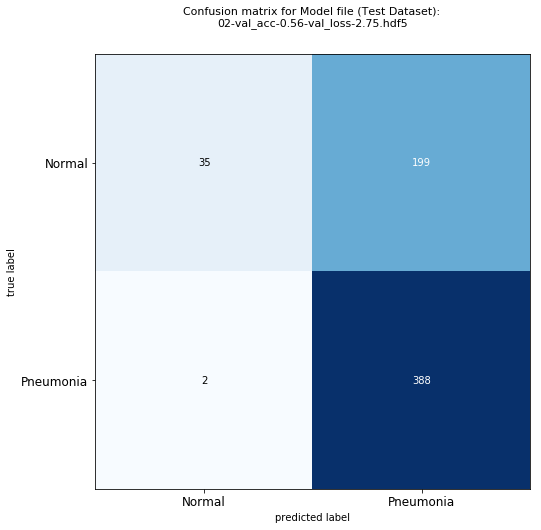




------------------------------------------------------------------------------------------
Report file for Model File :  02-val_acc-0.56-val_loss-2.75.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.95      0.15      0.26       234
   Pneumonia       0.66      0.99      0.79       390

    accuracy                           0.68       624
   macro avg       0.80      0.57      0.53       624
weighted avg       0.77      0.68      0.59       624

------------------------------------------------------------------------------------------


In [90]:
image_file_name_CM = figure_directory + '/CM'
title = model_file.split('/')
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('-', 90)
print('Derived Report')
print('-', 90)
print("%s%.2f%s"% ("Precision     : ", precision * 100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall * 100, "%"))
print("%s%.2f%s"% ("F1 Score      : ", f1 * 100, "%"))
print("-", 90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat = CM, figsize=(10,8), hide_ticks = True, cmap = plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize = 12)
plt.yticks(range(len(classes)), classes, fontsize = 12)
plt.title("Confusion matrix for Model file (Test Dataset): \n"+ model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi = 100)
plt.show()

cls_report_print = classification_report(y_true, y_pred, target_names = classes)

cls_report = classification_report(y_true, y_pred, target_names = classes, output_dict = True)

print("\n\n")
print("-"*90)
print("Report file for Model File : ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [91]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch - 1)

y_img_batch, y_true_batch = test_generator[batch_no]
y_true_batch = y_true_batch.argmax(axis = -1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis = -1)

sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 67.79%
-----------------------------------


**Visualization**

In [0]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample = True):
  fig, axs = get_fig_axs(subplot_params)
  plt.rcParams.update({'axes.titlesize': plot_params['axes_titlesize']})
  plt.subplots_adjust(hspace = subplot_params['hspace'], wspace = subplot_params['wspace'])
  
  file_names = test_generator.filenames
  m = {}
  length = len(y_true)
  for i in range(0, count):
    num = i
    if sample:
      num = random.randint(0, length - 1)
      while num in m:
        num = int(random.randint(0, length - 1))
        
      m[num] = 1
      
    plt.subplot(subplot_params['nrows'], subplot_params['ncols'], i+1)
    img = cv2.imread(testing_dir + '/' + file_names[num], 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
  
    original = class_map[y_true[num]]
    predicted = class_map[y_pred[num]]

    title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))

    if original==predicted:
        plt.title(title_text)
    else:
        plt.title(title_text, color='red')


    if plot_params["update_image"] and os.path.exists(image_file_name):
        os.remove(image_file_name)   

    fig.savefig(image_file_name, dpi=subplot_params["dpi"])

  plt.tight_layout()
  plt.show()

In [0]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

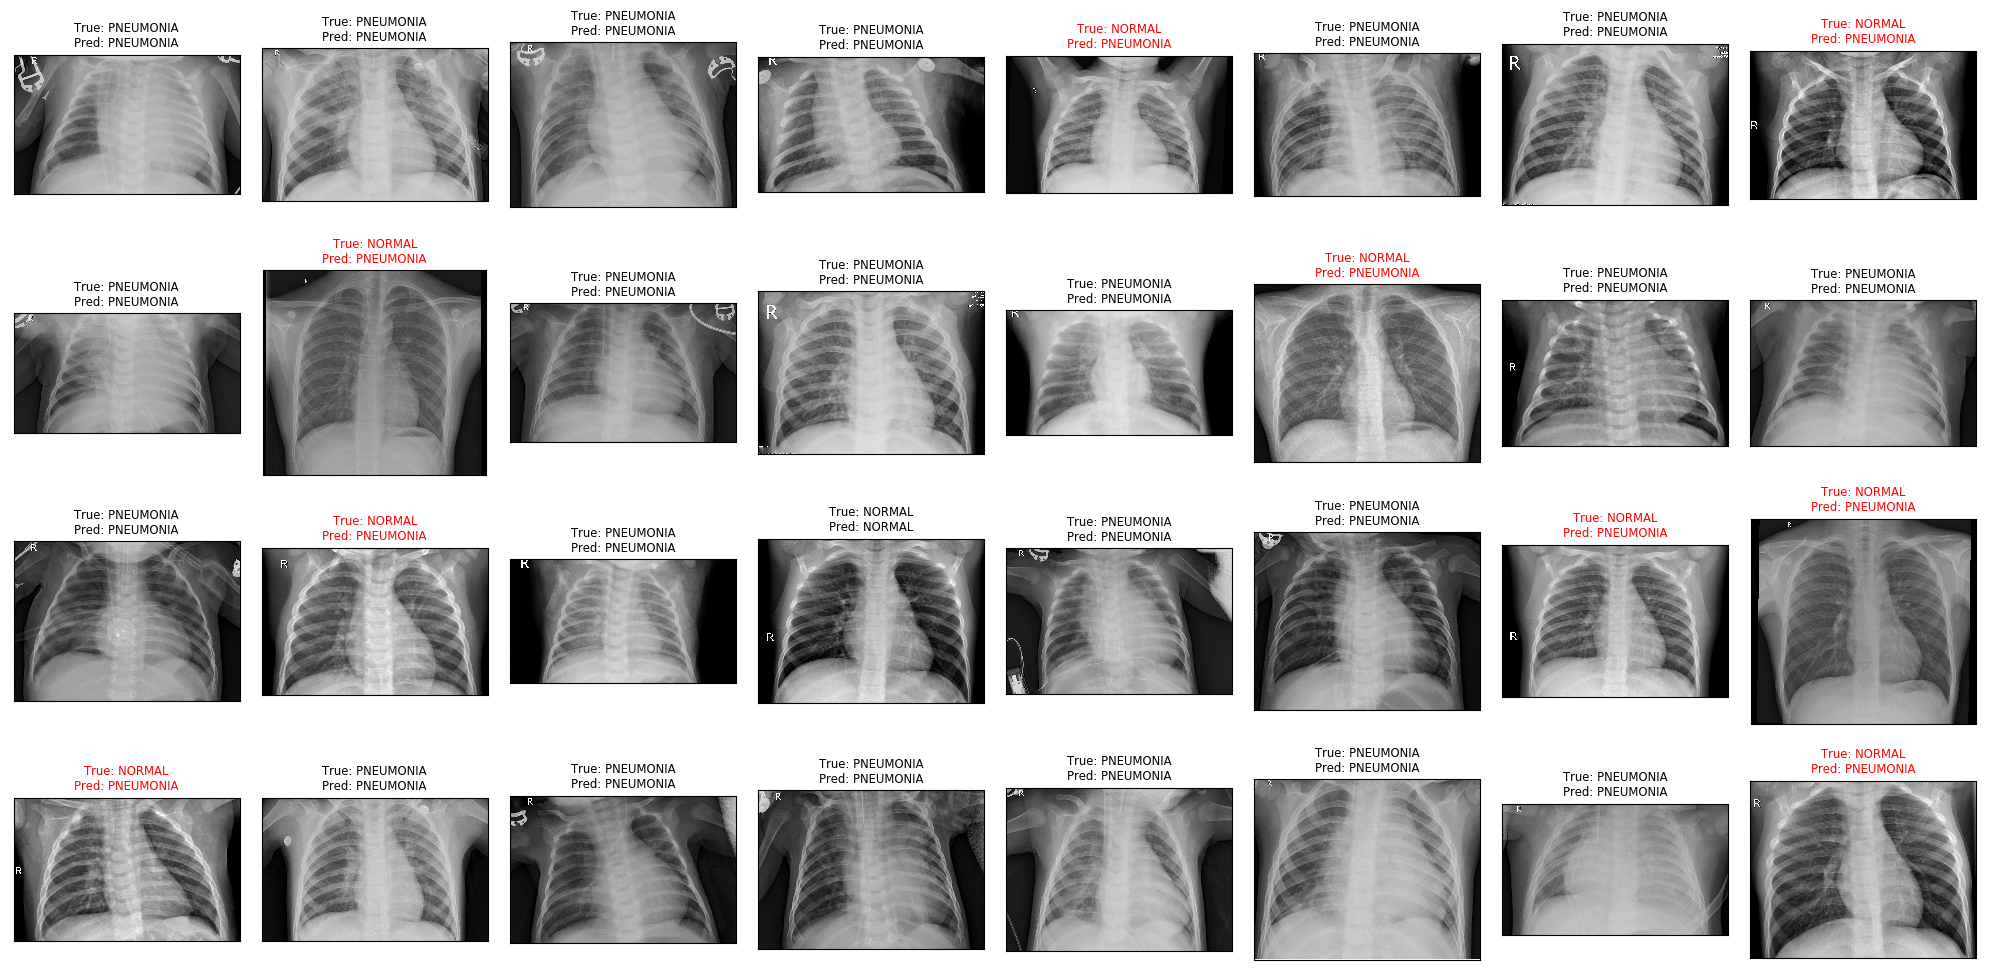

In [129]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

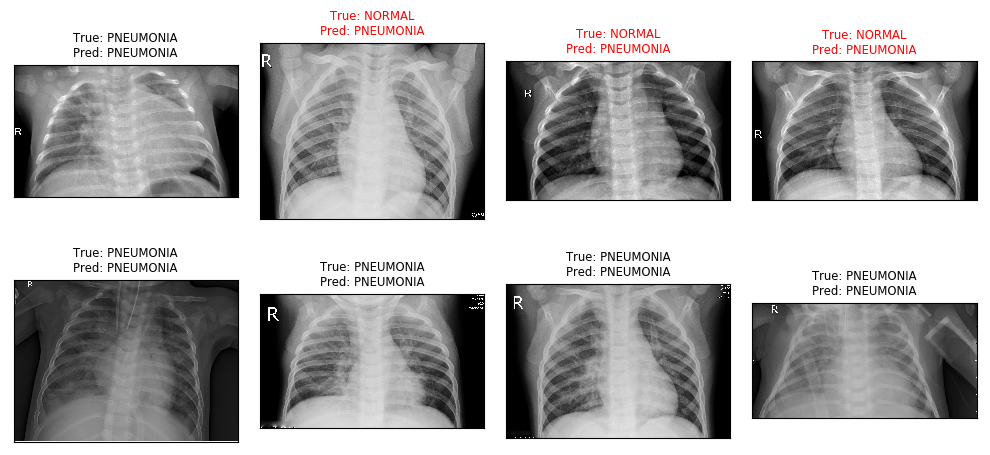

In [133]:
ncols = 4
nrows = 2

if batch_size_t<4:
    ncols = 1
    
count = ncols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)